In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
urban_function_df = gpd.read_file(r'C:\Users\user\OneDrive - hull.ac.uk\Desktop\Python\Induction\Project\Urban Analysis London\Research Data\urban_function_analysis_data.gpkg')
urban_function_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13112 entries, 0 to 13111
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   CELLCODE                                13112 non-null  object  
 1   groupname                               13112 non-null  object  
 2   landuse_de                              13112 non-null  object  
 3   index_right                             13112 non-null  float64 
 4   name                                    13112 non-null  object  
 5   categoryname                            13112 non-null  object  
 6   classname                               13112 non-null  object  
 7   pos_accuracy                            13112 non-null  float64 
 8   poi_Accommodation, Eating and Drinking  13112 non-null  float64 
 9   poi_Attractions                         13112 non-null  float64 
 10  poi_Commercial Services               

In [3]:
urban_function_df['Landuse_Category'].unique()

array(['Transport', 'Industrial', 'Natural', 'Commercial', 'Residential',
       'Agricultural', 'Recreational', 'Water'], dtype=object)

#### Random Forest

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

In [5]:
# Define feature columns (excluding non-numeric and irrelevant ones)
feature_columns = [
    'poi_Accommodation, Eating and Drinking', 'poi_Attractions', 'poi_Commercial Services', 'poi_Education and Health', 
    'poi_Manufacturing and Production', 'poi_Public Infrastructure', 'poi_Retail', 'poi_Sport and Entertainment',
    'poi_Transport', 'busstop_count', 'cycleshare_terminal', 'total_bike_count', 'total_commercial_poi', 'poi_total', 'poi_density', 
    'busstop_density', 'area'
]

# Extract features and target from the DataFrame
X = urban_function_df[feature_columns]
y = urban_function_df['Landuse_Category']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

Agricultural       0.67      0.61      0.64       206
  Commercial       0.85      0.56      0.68       141
  Industrial       0.78      0.71      0.74       231
     Natural       0.79      0.66      0.72       539
Recreational       0.62      0.26      0.36       129
 Residential       0.85      0.96      0.90      2554
   Transport       0.18      0.06      0.09        32
       Water       0.80      0.35      0.49       102

    accuracy                           0.83      3934
   macro avg       0.69      0.52      0.58      3934
weighted avg       0.82      0.83      0.81      3934



In [9]:
# Print classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Calculate average metrics from the classification report
avg_f1 = report['macro avg']['f1-score']
avg_precision = report['macro avg']['precision']
avg_recall = report['macro avg']['recall']

print(f"Average F1-score: {avg_f1:.2f}")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")

# Binarize the output for AUC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
y_pred_prob = rf_model.predict_proba(X_test)

# Compute AUC for each class
auc = roc_auc_score(y_test_bin, y_pred_prob, average="macro", multi_class="ovr")

print(f"Average AUC: {auc:.2f}")

Average F1-score: 0.58
Average Precision: 0.69
Average Recall: 0.52
Average AUC: 0.92


In [10]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 125,    0,    7,   12,    4,   54,    4,    0],
       [   2,   79,    6,    9,    1,   43,    0,    1],
       [   6,    0,  163,    5,    0,   55,    0,    2],
       [  17,    7,    7,  357,    2,  149,    0,    0],
       [   3,    0,    5,    7,   33,   79,    1,    1],
       [  26,    4,   13,   34,    7, 2461,    4,    5],
       [   1,    2,    2,    8,    6,   11,    2,    0],
       [   7,    1,    6,   18,    0,   34,    0,   36]], dtype=int64)

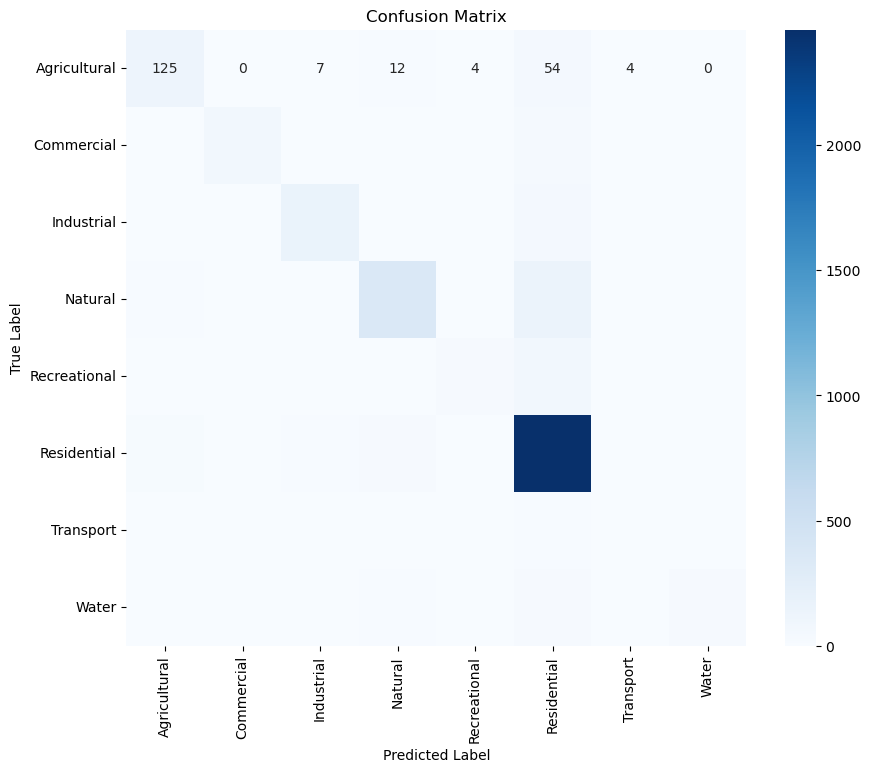

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Feature Importance

In [12]:
# G Feature Importance
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("Top 10 Features by Importance:")
print(importance_df.head(10))

Top 10 Features by Importance:
                             Feature  Importance
14                       poi_density    0.167977
15                   busstop_density    0.129469
16                              area    0.103402
2            poi_Commercial Services    0.064443
3           poi_Education and Health    0.062200
13                         poi_total    0.062110
5          poi_Public Infrastructure    0.060567
12              total_commercial_poi    0.055824
8                      poi_Transport    0.052610
4   poi_Manufacturing and Production    0.048925


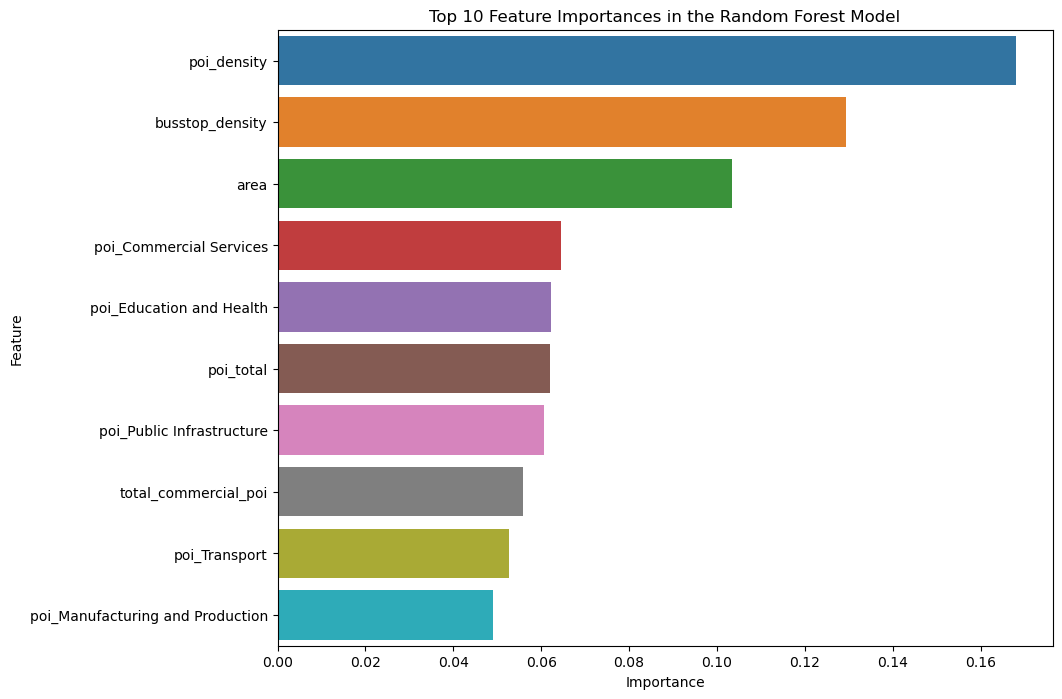

In [13]:
# Plot the top 10 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances in the Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Using Grid search on all the data

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

In [16]:
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Print the best parameters and best score
print("Best parameters found by grid search:", grid_search.best_params_)
print("Best cross-validation accuracy score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found by grid search: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy score: 0.8115058799783915


In [17]:
# Evaluate the best model on the test data
test_accuracy = best_rf_model.score(X_test, y_test)
print(f"Test Accuracy with Best Model: {test_accuracy:.2f}")

Test Accuracy with Best Model: 0.83


In [18]:
# Make predictions on the test data using the best model
y_pred_best = best_rf_model.predict(X_test)

# Print the classification report for the best model
print("Classification Report for Best Model:")
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

Classification Report for Best Model:
              precision    recall  f1-score   support

Agricultural       0.69      0.61      0.65       206
  Commercial       0.88      0.58      0.70       141
  Industrial       0.79      0.72      0.75       231
     Natural       0.80      0.65      0.72       539
Recreational       0.68      0.26      0.38       129
 Residential       0.85      0.97      0.91      2554
   Transport       0.14      0.06      0.09        32
       Water       0.78      0.35      0.49       102

    accuracy                           0.83      3934
   macro avg       0.70      0.53      0.59      3934
weighted avg       0.82      0.83      0.82      3934



In [19]:
# Print classification report
report_best = classification_report(y_test, y_pred_best, target_names=label_encoder.classes_, output_dict=True)

# Calculate average metrics from the classification report
avg_f1_best = report_best['macro avg']['f1-score']
avg_precision_best = report_best['macro avg']['precision']
avg_recall_best = report_best['macro avg']['recall']

print(f"Average F1-score: {avg_f1_best:.2f}")
print(f"Average Precision: {avg_precision_best:.2f}")
print(f"Average Recall: {avg_recall_best:.2f}")

# Binarize the output for AUC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
y_pred_prob_best = best_rf_model.predict_proba(X_test)

# Compute AUC for each class
auc_best = roc_auc_score(y_test_bin, y_pred_prob_best, average="macro", multi_class="ovr")

print(f"Average AUC: {auc_best:.2f}")

Average F1-score: 0.59
Average Precision: 0.70
Average Recall: 0.53
Average AUC: 0.93


In [20]:
import joblib

# Save the best model to a file
joblib_file = "best_rf_model.pkl"
joblib.dump(best_rf_model, joblib_file)

print(f"Model saved to {joblib_file}")

Model saved to best_rf_model.pkl


## Using the Top 10 Most Important features

In [21]:
# Define the top 10 important features
top_10_features = [
    'poi_density', 'busstop_density', 'area', 'poi_Commercial Services', 
    'poi_Education and Health', 'poi_total', 'poi_Public Infrastructure', 
    'total_commercial_poi', 'poi_Transport', 'poi_Manufacturing and Production'
]

# Extract features and target from the DataFrame
X = urban_function_df[top_10_features]
y = urban_function_df['Landuse_Category']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [22]:
# Initialize the Random Forest Classifier with the top 10 features
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Print the classification report
print("Classification Report (Top 10 Features):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report (Top 10 Features):
              precision    recall  f1-score   support

Agricultural       0.71      0.60      0.65       206
  Commercial       0.88      0.57      0.70       141
  Industrial       0.78      0.73      0.75       231
     Natural       0.81      0.67      0.73       539
Recreational       0.59      0.30      0.40       129
 Residential       0.85      0.97      0.91      2554
   Transport       0.10      0.03      0.05        32
       Water       0.76      0.31      0.44       102

    accuracy                           0.83      3934
   macro avg       0.69      0.52      0.58      3934
weighted avg       0.82      0.83      0.82      3934



In [24]:
# Print classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Calculate average metrics from the classification report
avg_f1 = report['macro avg']['f1-score']
avg_precision = report['macro avg']['precision']
avg_recall = report['macro avg']['recall']

print(f"Average F1-score: {avg_f1:.2f}")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")

# Binarize the output for AUC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
y_pred_prob = rf_model.predict_proba(X_test)

# Compute AUC for each class
auc = roc_auc_score(y_test_bin, y_pred_prob, average="macro", multi_class="ovr")

print(f"Average AUC: {auc:.2f}")

Average F1-score: 0.58
Average Precision: 0.69
Average Recall: 0.52
Average AUC: 0.92


#### Using Grid search on the top Ten Features

In [25]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

In [26]:
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [27]:
# Print the best parameters and best score
print("Best parameters found by grid search:", grid_search.best_params_)
print("Best cross-validation accuracy score:", grid_search.best_score_)

# Evaluate the best model on the test data
test_accuracy = best_rf_model.score(X_test, y_test)
print(f"Test Accuracy with Best Model: {test_accuracy:.2f}")

# Make predictions on the test data
y_pred_best = best_rf_model.predict(X_test)

# Print classification report
report_best = classification_report(y_test, y_pred_best, target_names=label_encoder.classes_, output_dict=True)

Best parameters found by grid search: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy score: 0.8094353321104402
Test Accuracy with Best Model: 0.83


In [28]:
# Calculate average metrics from the classification report
avg_f1_best = report_best['macro avg']['f1-score']
avg_precision_best = report_best['macro avg']['precision']
avg_recall_best = report_best['macro avg']['recall']

print(f"Average F1-score: {avg_f1_best:.2f}")
print(f"Average Precision: {avg_precision_best:.2f}")
print(f"Average Recall: {avg_recall_best:.2f}")

# Binarize the output for AUC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
y_pred_prob_best = best_rf_model.predict_proba(X_test)

# Compute AUC for each class
auc_best = roc_auc_score(y_test_bin, y_pred_prob_best, average="macro", multi_class="ovr")

print(f"Average AUC: {auc_best:.2f}")

Average F1-score: 0.58
Average Precision: 0.69
Average Recall: 0.52
Average AUC: 0.93


##### Incorporate SMOTE into Random Forest Model

In [29]:
from imblearn.over_sampling import SMOTE

In [30]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [31]:
# Initialize the Random Forest Classifier again
rf_model_smote = RandomForestClassifier(random_state=42)

# Train the model on the SMOTE data
rf_model_smote.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [32]:
# Make predictions on the test data
y_pred_smote = rf_model_smote.predict(X_test)

# Print the classification report for SMOTE model
print("Classification Report with SMOTE (Top 10 Features):")
print(classification_report(y_test, y_pred_smote, target_names=label_encoder.classes_))

Classification Report with SMOTE (Top 10 Features):
              precision    recall  f1-score   support

Agricultural       0.56      0.67      0.61       206
  Commercial       0.42      0.54      0.47       141
  Industrial       0.53      0.75      0.62       231
     Natural       0.69      0.66      0.67       539
Recreational       0.34      0.56      0.42       129
 Residential       0.93      0.85      0.89      2554
   Transport       0.17      0.22      0.19        32
       Water       0.46      0.39      0.42       102

    accuracy                           0.77      3934
   macro avg       0.51      0.58      0.54      3934
weighted avg       0.80      0.77      0.78      3934



In [33]:
# Calculate accuracy
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f"Test Accuracy with SMOTE Model: {accuracy_smote:.2f}")

# Print the classification report for SMOTE model
report_smote = classification_report(y_test, y_pred_smote, target_names=label_encoder.classes_, output_dict=True)

# Calculate average metrics from the classification report
avg_f1_smote = report_smote['macro avg']['f1-score']
avg_precision_smote = report_smote['macro avg']['precision']
avg_recall_smote = report_smote['macro avg']['recall']

print(f"Average F1-score: {avg_f1_smote:.2f}")
print(f"Average Precision: {avg_precision_smote:.2f}")
print(f"Average Recall: {avg_recall_smote:.2f}")

Test Accuracy with SMOTE Model: 0.77
Average F1-score: 0.54
Average Precision: 0.51
Average Recall: 0.58


#### Grid Search with SMOTE
Incorporating Grid Search to find the best hyperparameters for the Random Forest model.

In [34]:
# Set up the grid search with cross-validation on SMOTE data
grid_search_smote = GridSearchCV(estimator=rf_model_smote, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

# Fit the grid search to the SMOTE training data
grid_search_smote.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [35]:
# Get the best model
best_rf_model_smote = grid_search_smote.best_estimator_

# Print the best parameters and best score for SMOTE data
print("Best parameters found by grid search with SMOTE:", grid_search_smote.best_params_)
print("Best cross-validation accuracy score with SMOTE:", grid_search_smote.best_score_)

Best parameters found by grid search with SMOTE: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy score with SMOTE: 0.9013677585225025


In [36]:
best_rf_model_smote

RandomForestClassifier(n_estimators=300, random_state=42)

In [37]:
# Evaluate the best SMOTE model on the test data
test_accuracy_smote = best_rf_model_smote.score(X_test, y_test)
print(f"Test Accuracy with Best Model and SMOTE: {test_accuracy_smote:.2f}")

# Make predictions with the best SMOTE model
y_pred_best_smote = best_rf_model_smote.predict(X_test)

# Print the classification report for the best SMOTE model
print("Classification Report for Best Model with SMOTE (Top 10 Features):")
print(classification_report(y_test, y_pred_best_smote, target_names=label_encoder.classes_))

Test Accuracy with Best Model and SMOTE: 0.77
Classification Report for Best Model with SMOTE (Top 10 Features):
              precision    recall  f1-score   support

Agricultural       0.55      0.67      0.60       206
  Commercial       0.44      0.56      0.49       141
  Industrial       0.54      0.74      0.62       231
     Natural       0.69      0.66      0.68       539
Recreational       0.34      0.56      0.42       129
 Residential       0.94      0.85      0.89      2554
   Transport       0.17      0.22      0.19        32
       Water       0.44      0.38      0.41       102

    accuracy                           0.77      3934
   macro avg       0.51      0.58      0.54      3934
weighted avg       0.80      0.77      0.78      3934



In [38]:
# Print the classification report for the best SMOTE model
report_best_smote = classification_report(y_test, y_pred_best_smote, target_names=label_encoder.classes_, output_dict=True)

# Calculate average metrics from the classification report
avg_f1_best_smote = report_best_smote['macro avg']['f1-score']
avg_precision_best_smote = report_best_smote['macro avg']['precision']
avg_recall_best_smote = report_best_smote['macro avg']['recall']

print(f"Average F1-score: {avg_f1_best_smote:.2f}")
print(f"Average Precision: {avg_precision_best_smote:.2f}")
print(f"Average Recall: {avg_recall_best_smote:.2f}")

# Binarize the output for AUC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
y_pred_prob_best_smote = best_rf_model_smote.predict_proba(X_test)

# Compute AUC for each class
auc_best_smote = roc_auc_score(y_test_bin, y_pred_prob_best_smote, average="macro", multi_class="ovr")

print(f"Average AUC: {auc_best_smote:.2f}")

Average F1-score: 0.54
Average Precision: 0.51
Average Recall: 0.58
Average AUC: 0.92


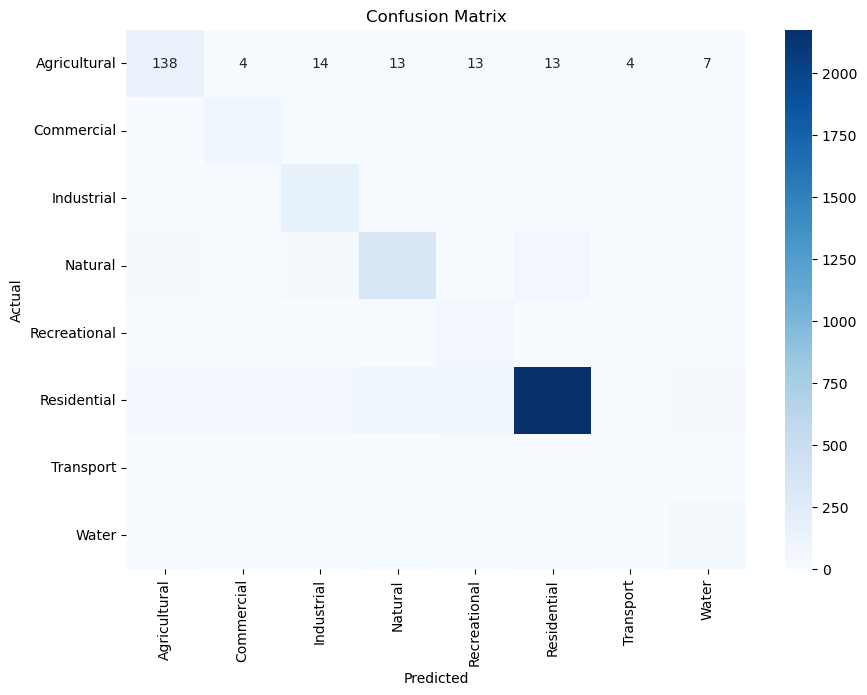

In [39]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best_smote)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### MLP

In [40]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [41]:
# Define feature columns (excluding non-numeric and irrelevant ones)
feature_columns = [
    'poi_Accommodation, Eating and Drinking', 'poi_Attractions', 'poi_Commercial Services', 'poi_Education and Health', 
    'poi_Manufacturing and Production', 'poi_Public Infrastructure', 'poi_Retail', 'poi_Sport and Entertainment',
    'poi_Transport', 'busstop_count', 'cycleshare_terminal', 'total_bike_count', 'total_commercial_poi', 'poi_total', 'poi_density', 
    'busstop_density', 'area'
]

# Extract features and target from the DataFrame
X = urban_function_df[feature_columns]
y = urban_function_df['Landuse_Category']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the target variable
y_categorical = to_categorical(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42, stratify=y_encoded)

In [42]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
# Define the MLP model
model1 = Sequential()
model1.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model1.summary()

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,080 (43.28 KB)

 Trainable params: 11,080 (43.28 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Train the model
history1 = model1.fit(X_train_scaled, y_train, epochs=25, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5446 - loss: 1.6539 - val_accuracy: 0.6585 - val_loss: 1.1359
Epoch 2/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6437 - loss: 1.2103 - val_accuracy: 0.6612 - val_loss: 1.0835
Epoch 3/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6466 - loss: 1.1369 - val_accuracy: 0.6569 - val_loss: 1.0680
Epoch 4/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6505 - loss: 1.0997 - val_accuracy: 0.6585 - val_loss: 1.0470
Epoch 5/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6456 - loss: 1.1009 - val_accuracy: 0.6525 - val_loss: 1.0391
Epoch 6/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6395 - loss: 1.0908 - val_accuracy: 0.6569 - val_loss: 1.0318
Epoch 7/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6501 - loss: 1.0768 - val_accuracy: 0.6590 - val_loss: 1.0252
Epoch 8/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6520 - loss: 1.0443 - val_accuracy: 0.

In [45]:
history1_df = pd.DataFrame(history1.history)
history1_df

,accuracy,loss,val_accuracy,val_loss
0,0.618769,1.438025,0.658497,1.135926
1,0.644375,1.176042,0.661220,1.083477
2,0.645601,1.139906,0.656863,1.067954
3,0.645464,1.107733,0.658497,1.047037
4,0.644511,1.091818,0.652505,1.039142
5,0.645873,1.082913,0.656863,1.031772
6,0.648597,1.077334,0.659041,1.025166
7,0.653909,1.057268,0.653050,1.015966
8,0.651730,1.050727,0.658497,1.009672
9,0.648052,1.052730,0.658497,1.004208


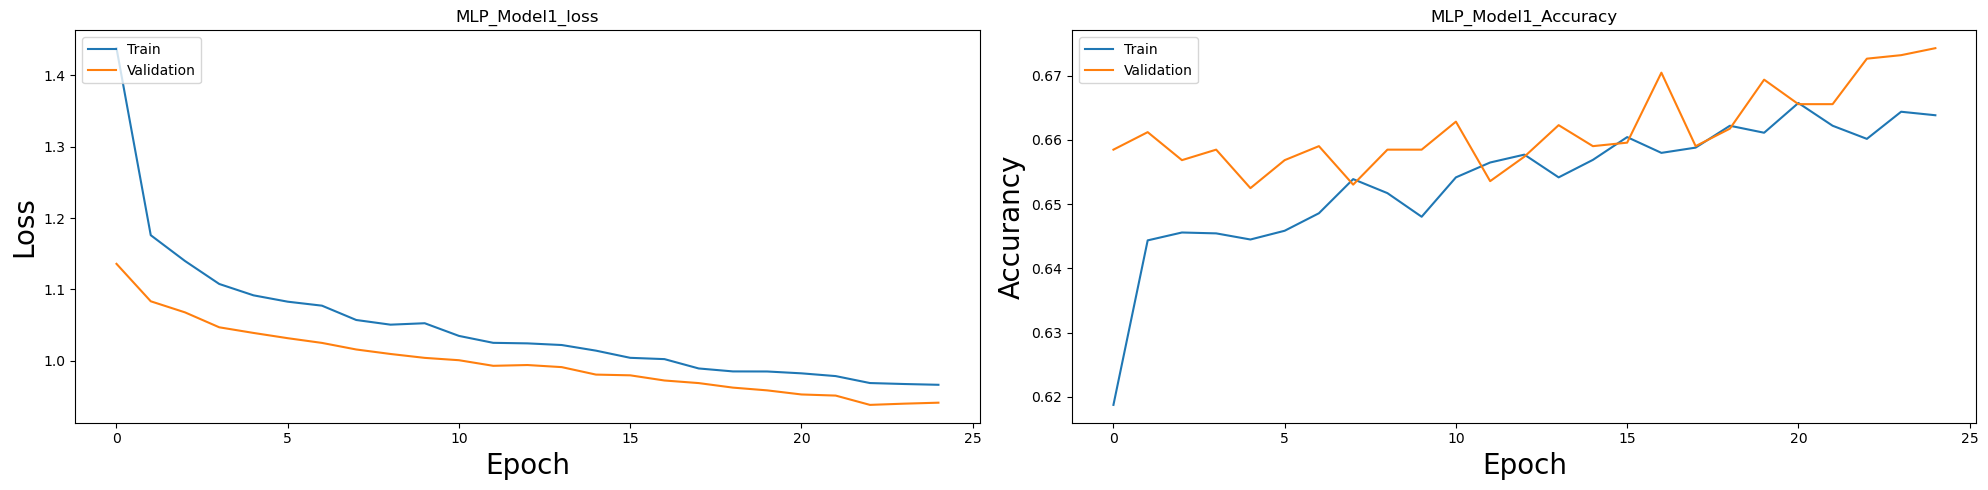

In [46]:
training_loss = history1_df['loss']
val_loss = history1_df['val_loss']
training_accurancy = history1_df['accuracy']
val_accurancy = history1_df ['val_accuracy']

#plot the loss
fig5, ax5 = plt.subplots(1,2, figsize =(20,5))
ax5[0].plot(training_loss)
ax5[0].plot(val_loss)
ax5[0].set_xlabel('Epoch', fontsize =20)
ax5[0].set_ylabel('Loss', fontsize =20)
ax5[0].set_title('MLP_Model1_loss')
ax5[0].legend(['Train', 'Validation'], loc='upper left')

#plot the accurancy
ax5[1].plot(training_accurancy)
ax5[1].plot(val_accurancy )
ax5[1].set_xlabel('Epoch', fontsize =20)
ax5[1].set_ylabel('Accurancy', fontsize =20)
ax5[1].set_title('MLP_Model1_Accuracy')
ax5[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()

In [47]:
# Evaluate the model on the test data
y_pred_prob = model1.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy_mlp = accuracy_score(y_test_true, y_pred)
print(f"MLP Accuracy: {accuracy_mlp:.2f}")

# Print classification report
print("MLP Classification Report:")
print(classification_report(y_test_true, y_pred, target_names=label_encoder.classes_))

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
MLP Accuracy: 0.67
MLP Classification Report:
              precision    recall  f1-score   support

Agricultural       1.00      0.00      0.01       206
  Commercial       1.00      0.01      0.01       141
  Industrial       0.41      0.13      0.20       231
     Natural       0.59      0.16      0.25       539
Recreational       0.00      0.00      0.00       129
 Residential       0.68      0.98      0.80      2554
   Transport       0.00      0.00      0.00        32
       Water       1.00      0.04      0.08       102

    accuracy                           0.67      3934
   macro avg       0.58      0.17      0.17      3934
weighted avg       0.66      0.67      0.57      3934



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# Calculate average metrics from the classification report
report_mlp = classification_report(y_test_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

avg_f1_mlp = report_mlp['macro avg']['f1-score']
avg_precision_mlp = report_mlp['macro avg']['precision']
avg_recall_mlp = report_mlp['macro avg']['recall']

print(f"Average F1-score: {avg_f1_mlp:.2f}")
print(f"Average Precision: {avg_precision_mlp:.2f}")
print(f"Average Recall: {avg_recall_mlp:.2f}")

# Binarize the output for AUC calculation
y_test_bin = label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(label_encoder.classes_)))

# Compute AUC for each class
auc_mlp = roc_auc_score(y_test_bin, y_pred_prob, average="macro", multi_class="ovr")

print(f"Average AUC: {auc_mlp:.2f}")

Average F1-score: 0.17
Average Precision: 0.58
Average Recall: 0.17
Average AUC: 0.82


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


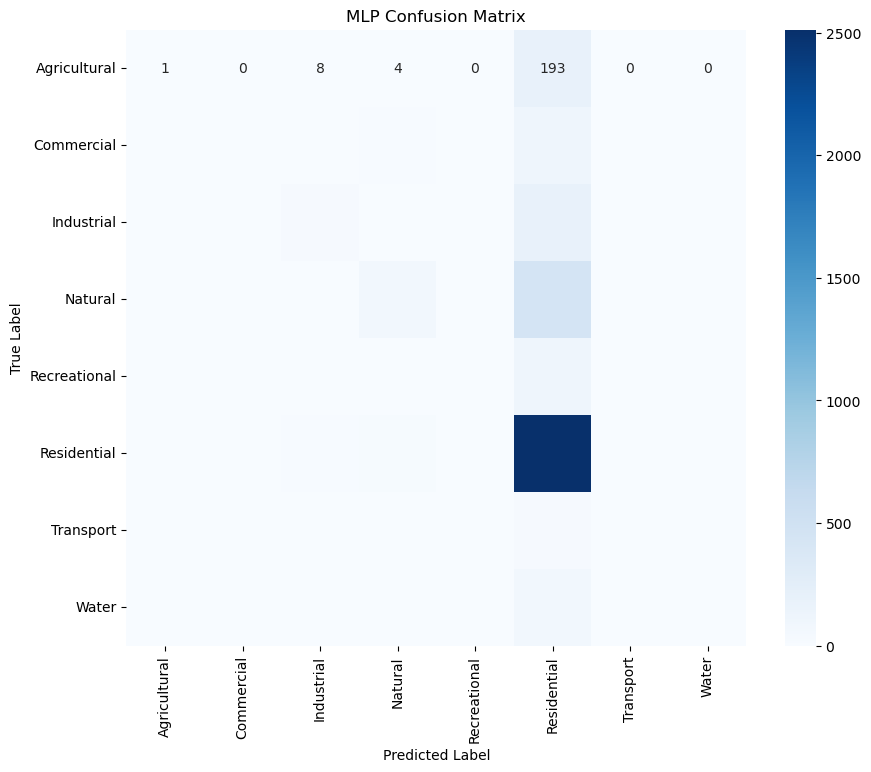

In [49]:
# Plot the confusion matrix
conf_matrix_mlp = confusion_matrix(y_test_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MLP Confusion Matrix')
plt.show()

#### Optimizing MLP

In [50]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [51]:
# Define the optimized MLP model
model2 = Sequential()

# Input layer with 128 units, an additional hidden layer with 128 units
model2.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model2.add(Dropout(0.4))  # Increased dropout rate to reduce overfitting

# Additional hidden layer with 128 units
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.4))  # Same dropout rate

# Another hidden layer with 64 units
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))

# Output layer
model2.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model with a slightly lower learning rate
optimizer = Adam(learning_rate=0.0005)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model2.summary()

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,592 (107.78 KB)

 Trainable params: 27,592 (107.78 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Train the optimized model
history2 = model2.fit(
    X_train_scaled, y_train, 
    epochs=50,  # Increased epochs to allow the model to converge better
    batch_size=32,  # Reduced batch size for potentially better generalization
    validation_split=0.2, 
    callbacks=[early_stopping, reduce_lr], 
    verbose=1)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6001 - loss: 1.6092 - val_accuracy: 0.6574 - val_loss: 1.1445 - learning_rate: 5.0000e-04
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6473 - loss: 1.2370 - val_accuracy: 0.6547 - val_loss: 1.0932 - learning_rate: 5.0000e-04
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6482 - loss: 1.1600 - val_accuracy: 0.6552 - val_loss: 1.0784 - learning_rate: 5.0000e-04
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6447 - loss: 1.1484 - val_accuracy: 0.6612 - val_loss: 1.0574 - learning_rate: 5.0000e-04
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6502 - loss: 1.1174 - val_accuracy: 0.6574 - val_loss: 1.0564 - learning_rate: 5.0000e-04
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6459 - loss: 1.1102 - val_accuracy: 0.6552 - val_loss: 1.0460 - learning_rate: 5.0000e-04
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 

In [53]:
history2_df = pd.DataFrame(history2.history)
history2_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.635930,1.444694,0.657407,1.144513,0.0005
1,0.645464,1.216066,0.654684,1.093177,0.0005
2,0.645873,1.168054,0.655229,1.078367,0.0005
3,0.645464,1.149534,0.661220,1.057384,0.0005
4,0.646554,1.129261,0.657407,1.056389,0.0005
5,0.646418,1.113723,0.655229,1.045967,0.0005
6,0.647235,1.109907,0.656318,1.041006,0.0005
7,0.648325,1.094287,0.657952,1.033470,0.0005
8,0.647099,1.087969,0.654139,1.027975,0.0005
9,0.650095,1.078788,0.653050,1.022130,0.0005


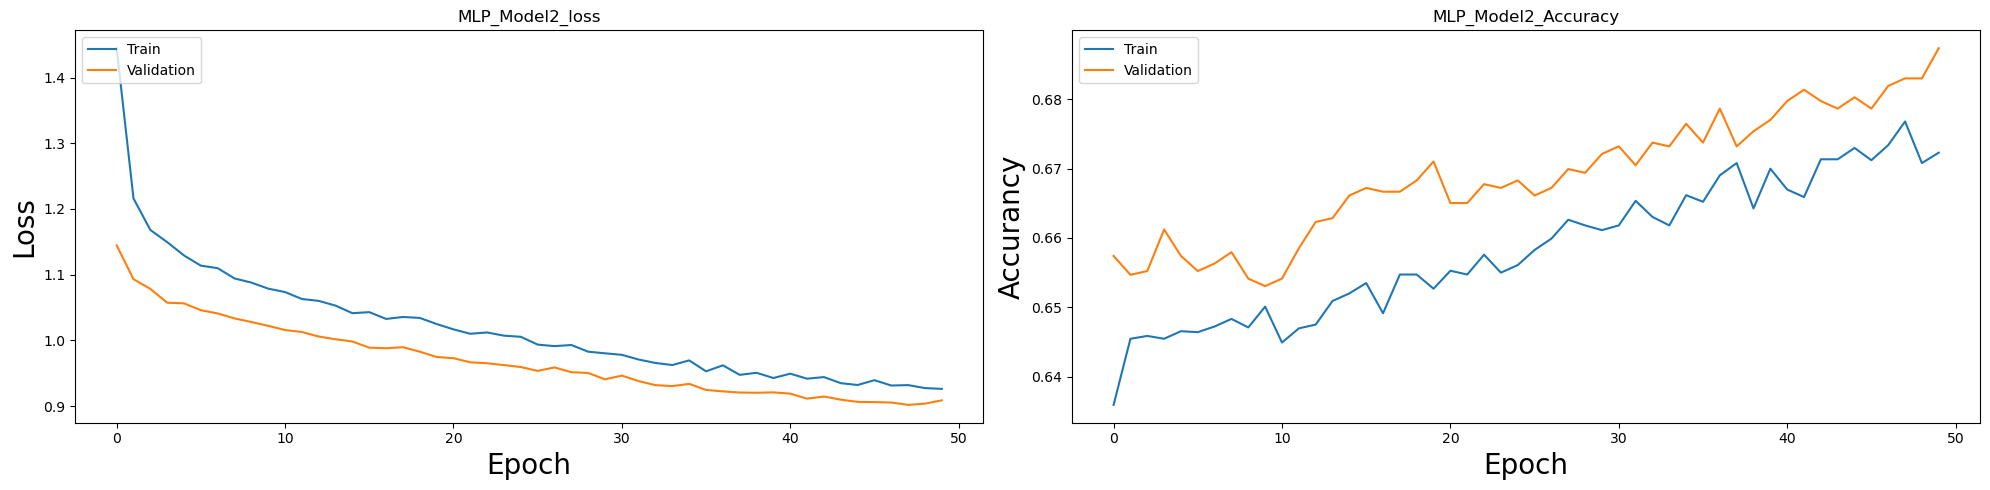

In [54]:
training_loss = history2_df['loss']
val_loss = history2_df['val_loss']
training_accurancy = history2_df['accuracy']
val_accurancy = history2_df ['val_accuracy']

#plot the loss
fig6, ax6 = plt.subplots(1,2, figsize =(20,5))
ax6[0].plot(training_loss)
ax6[0].plot(val_loss)
ax6[0].set_xlabel('Epoch', fontsize =20)
ax6[0].set_ylabel('Loss', fontsize =20)
ax6[0].set_title('MLP_Model2_loss')
ax6[0].legend(['Train', 'Validation'], loc='upper left')

#plot the accurancy
ax6[1].plot(training_accurancy)
ax6[1].plot(val_accurancy )
ax6[1].set_xlabel('Epoch', fontsize =20)
ax6[1].set_ylabel('Accurancy', fontsize =20)
ax6[1].set_title('MLP_Model2_Accuracy')
ax6[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()

In [55]:
# Evaluate the model on the test data
y_pred_prob = model2.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy_mlp = accuracy_score(y_test_true, y_pred)
print(f"Optimised MLP Accuracy: {accuracy_mlp:.2f}")

# Print classification report
print("MLP Classification Report:")
print(classification_report(y_test_true, y_pred, target_names=label_encoder.classes_))

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Optimised MLP Accuracy: 0.68
MLP Classification Report:
              precision    recall  f1-score   support

Agricultural       0.44      0.17      0.24       206
  Commercial       0.50      0.01      0.01       141
  Industrial       0.45      0.16      0.24       231
     Natural       0.53      0.24      0.33       539
Recreational       0.00      0.00      0.00       129
 Residential       0.70      0.96      0.81      2554
   Transport       0.00      0.00      0.00        32
       Water       0.78      0.07      0.13       102

    accuracy                           0.68      3934
   macro avg       0.42      0.20      0.22      3934
weighted avg       0.61      0.68      0.60      3934



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
# Calculate average metrics from the classification report
report_mlp_optimized = classification_report(y_test_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

avg_f1_mlp_optimized = report_mlp_optimized['macro avg']['f1-score']
avg_precision_mlp_optimized = report_mlp_optimized['macro avg']['precision']
avg_recall_mlp_optimized = report_mlp_optimized['macro avg']['recall']

print(f"Average F1-score: {avg_f1_mlp_optimized:.2f}")
print(f"Average Precision: {avg_precision_mlp_optimized:.2f}")
print(f"Average Recall: {avg_recall_mlp_optimized:.2f}")

# Binarize the output for AUC calculation
y_test_bin = label_binarize(y_test_true, classes=np.arange(len(label_encoder.classes_)))

# Compute AUC for each class
auc_mlp_optimized = roc_auc_score(y_test_bin, y_pred_prob, average="macro", multi_class="ovr")

print(f"Average AUC: {auc_mlp_optimized:.2f}")

Average F1-score: 0.22
Average Precision: 0.42
Average Recall: 0.20
Average AUC: 0.84


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Optimizing with SMOTE

In [58]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train.argmax(axis=1))

# Convert the resampled target back to categorical
y_train_smote = to_categorical(y_train_smote, num_classes=len(label_encoder.classes_))

In [59]:
# Define the optimized MLP model with SMOTE data
model_smote = Sequential()
model_smote.add(Dense(128, input_dim=X_train_smote.shape[1], activation='relu'))
model_smote.add(Dropout(0.4))
model_smote.add(Dense(128, activation='relu'))
model_smote.add(Dropout(0.4))
model_smote.add(Dense(64, activation='relu'))
model_smote.add(Dropout(0.3))
model_smote.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model with a reduced learning rate
optimizer = Adam(learning_rate=0.0005)
model_smote.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_smote.summary()

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 128)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,592 (107.78 KB)

 Trainable params: 27,592 (107.78 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Train the model on SMOTE balanced data
history_smote = model_smote.fit(
    X_train_smote, y_train_smote, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping, reduce_lr], 
    verbose=1
)

Epoch 1/50
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.2644 - loss: 1.8855 - val_accuracy: 0.0147 - val_loss: 3.6825 - learning_rate: 5.0000e-04
Epoch 2/50
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3659 - loss: 1.6710 - val_accuracy: 0.0181 - val_loss: 3.5751 - learning_rate: 5.0000e-04
Epoch 3/50
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4076 - loss: 1.5798 - val_accuracy: 0.0200 - val_loss: 3.5894 - learning_rate: 5.0000e-04
Epoch 4/50
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4419 - loss: 1.4944 - val_accuracy: 0.0940 - val_loss: 3.3426 - learning_rate: 5.0000e-04
Epoch 5/50
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4730 - loss: 1.4238 - val_accuracy: 0.1271 - val_loss: 3.3757 - learning_rate: 5.0000e-04
Epoch 6/50
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4954 - loss: 1.3735 - val_accuracy: 0.1590 - val_loss: 3.2178 - learning_rate: 5.0000e-04
Epoch 7/50
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/st

In [61]:
history_smote_df = pd.DataFrame(history_smote.history)
history_smote_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.306054,1.797860,0.014683,3.682458,0.000500
1,0.380995,1.642796,0.018144,3.575133,0.000500
2,0.420615,1.555348,0.020031,3.589385,0.000500
3,0.450088,1.476702,0.093970,3.342593,0.000500
4,0.478171,1.411014,0.127111,3.375731,0.000500
5,0.499331,1.362581,0.158993,3.217805,0.000500
6,0.515457,1.326341,0.165600,3.109565,0.000500
7,0.531898,1.288318,0.182486,3.082579,0.000500
8,0.547605,1.255410,0.171893,3.111457,0.000500
9,0.555419,1.235081,0.211222,3.130976,0.000500


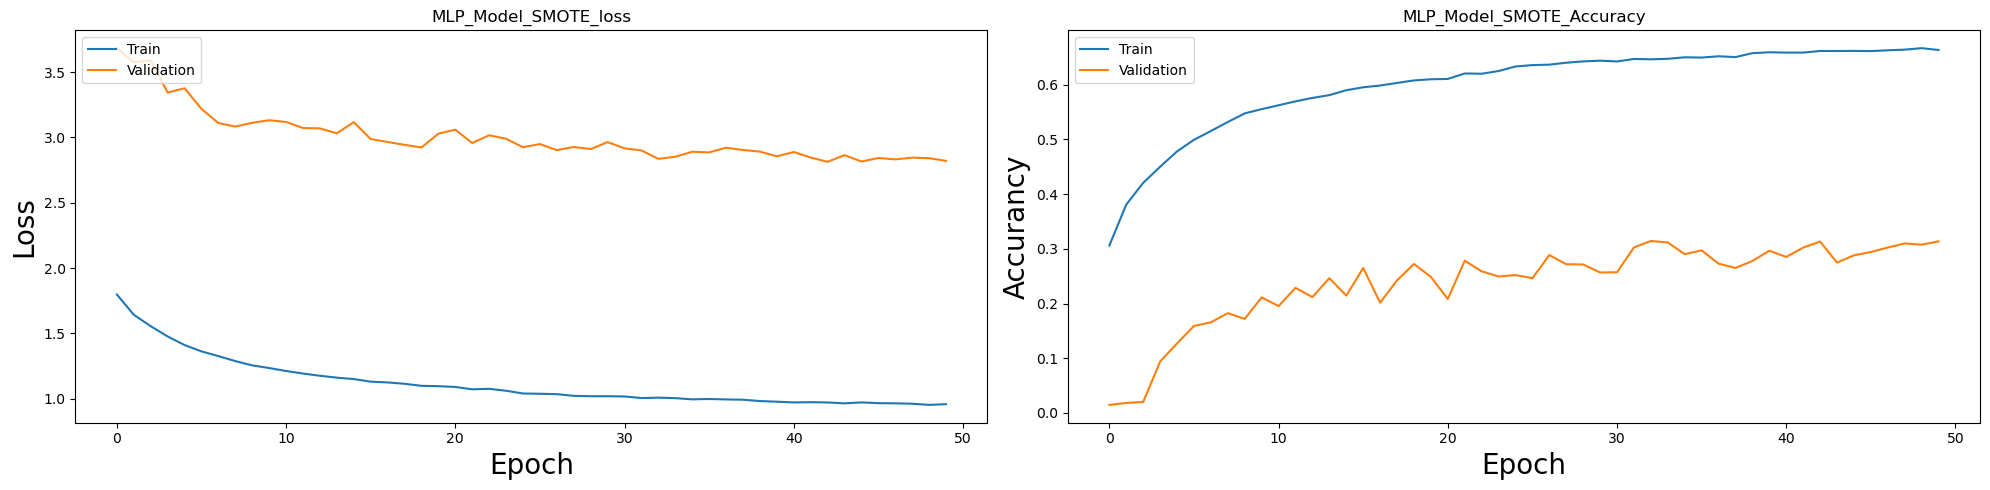

In [62]:
training_loss = history_smote_df['loss']
val_loss = history_smote_df['val_loss']
training_accurancy = history_smote_df['accuracy']
val_accurancy = history_smote_df ['val_accuracy']

#plot the loss
fig7, ax7 = plt.subplots(1,2, figsize =(20,5))
ax7[0].plot(training_loss)
ax7[0].plot(val_loss)
ax7[0].set_xlabel('Epoch', fontsize =20)
ax7[0].set_ylabel('Loss', fontsize =20)
ax7[0].set_title('MLP_Model_SMOTE_loss')
ax7[0].legend(['Train', 'Validation'], loc='upper left')

#plot the accurancy
ax7[1].plot(training_accurancy)
ax7[1].plot(val_accurancy )
ax7[1].set_xlabel('Epoch', fontsize =20)
ax7[1].set_ylabel('Accurancy', fontsize =20)
ax7[1].set_title('MLP_Model_SMOTE_Accuracy')
ax7[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()

In [63]:
# Evaluate the model on the test data
y_pred_prob = model_smote.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy_mlp = accuracy_score(y_test_true, y_pred)
print(f"Optimised MLP Accuracy with SMOTE: {accuracy_mlp:.2f}")

# Print classification report
print("MLP Classification Report:")
print(classification_report(y_test_true, y_pred, target_names=label_encoder.classes_))

123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Optimised MLP Accuracy with SMOTE: 0.53
MLP Classification Report:
              precision    recall  f1-score   support

Agricultural       0.32      0.58      0.41       206
  Commercial       0.23      0.49      0.31       141
  Industrial       0.31      0.68      0.43       231
     Natural       0.40      0.55      0.46       539
Recreational       0.18      0.62      0.28       129
 Residential       0.95      0.53      0.68      2554
   Transport       0.03      0.09      0.04        32
       Water       1.00      0.02      0.04       102

    accuracy                           0.53      3934
   macro avg       0.43      0.45      0.33      3934
weighted avg       0.74      0.53      0.58      3934



In [64]:
# Calculate average metrics from the classification report
report_mlp_smote = classification_report(y_test_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

avg_f1_mlp_smote = report_mlp_smote['macro avg']['f1-score']
avg_precision_mlp_smote = report_mlp_smote['macro avg']['precision']
avg_recall_mlp_smote = report_mlp_smote['macro avg']['recall']

print(f"Average F1-score: {avg_f1_mlp_smote:.2f}")
print(f"Average Precision: {avg_precision_mlp_smote:.2f}")
print(f"Average Recall: {avg_recall_mlp_smote:.2f}")

# Binarize the output for AUC calculation
y_test_bin = label_binarize(y_test_true, classes=np.arange(len(label_encoder.classes_)))

# Compute AUC for each class
auc_mlp_smote = roc_auc_score(y_test_bin, y_pred_prob, average="macro", multi_class="ovr")

print(f"Average AUC: {auc_mlp_smote:.2f}")

Average F1-score: 0.33
Average Precision: 0.43
Average Recall: 0.45
Average AUC: 0.85


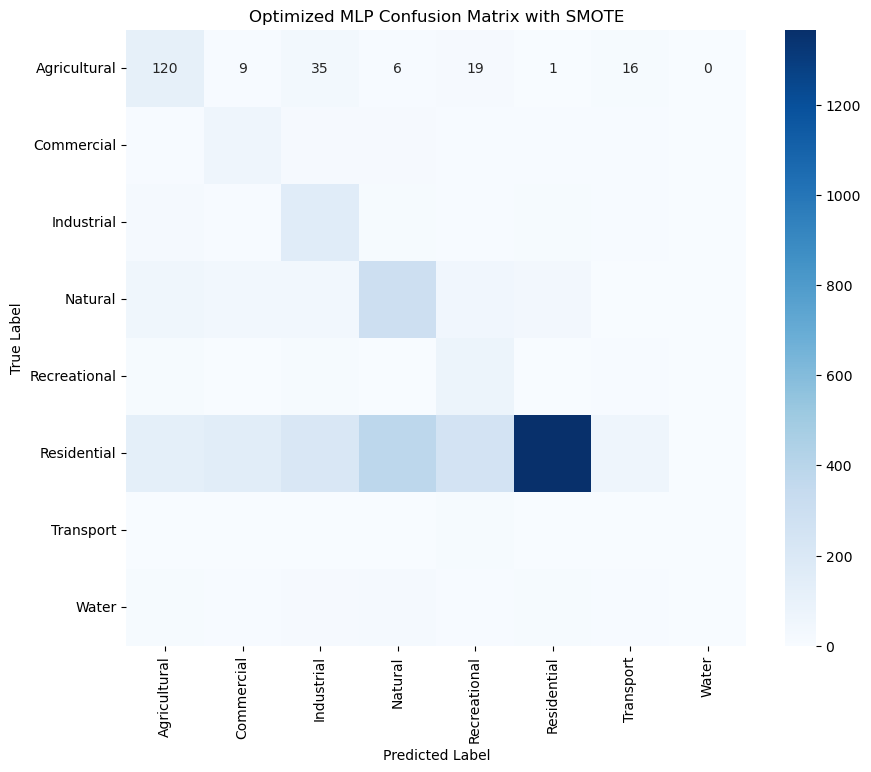

In [65]:
# Plot the confusion matrix
conf_matrix_mlp2 = confusion_matrix(y_test_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mlp2, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Optimized MLP Confusion Matrix with SMOTE')
plt.show()

#### Using TOp 10 with MLP

In [66]:
top_10_features = [
    'poi_density', 'busstop_density', 'area', 'poi_Commercial Services', 
    'poi_Education and Health', 'poi_total', 'poi_Public Infrastructure', 
    'total_commercial_poi', 'poi_Transport', 'poi_Manufacturing and Production'
]

# Extract features and target
X = urban_function_df[top_10_features]
y = urban_function_df['Landuse_Category']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the target variable
y_categorical = to_categorical(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42, stratify=y_encoded)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train.argmax(axis=1))

In [67]:
# Convert the resampled target back to categorical
y_train_smote = to_categorical(y_train_smote, num_classes=len(label_encoder.classes_))

# Define the simple MLP model with SMOTE data
model_simple_smote = Sequential()
model_simple_smote.add(Dense(128, input_dim=X_train_smote.shape[1], activation='relu'))
model_simple_smote.add(Dropout(0.3))
model_simple_smote.add(Dense(64, activation='relu'))
model_simple_smote.add(Dropout(0.3))
model_simple_smote.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_simple_smote.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_simple_smote.summary()

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,184 (39.78 KB)

 Trainable params: 10,184 (39.78 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Train the model on SMOTE balanced data
history_simple_smote = model_simple_smote.fit(
    X_train_smote, y_train_smote, 
    epochs=25,  # Using a basic setup with 25 epochs
    batch_size=64,  # Batch size is set to 64
    validation_split=0.2, 
    verbose=1
)

Epoch 1/25
596/596 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2878 - loss: 1.8522 - val_accuracy: 0.0149 - val_loss: 3.8201
Epoch 2/25
596/596 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3856 - loss: 1.6145 - val_accuracy: 0.0326 - val_loss: 3.8114
Epoch 3/25
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4317 - loss: 1.5110 - val_accuracy: 0.0784 - val_loss: 3.4992
Epoch 4/25
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4652 - loss: 1.4297 - val_accuracy: 0.0887 - val_loss: 3.6140
Epoch 5/25
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4839 - loss: 1.3872 - val_accuracy: 0.1449 - val_loss: 3.5415
Epoch 6/25
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4947 - loss: 1.3559 - val_accuracy: 0.1623 - val_loss: 3.3589
Epoch 7/25
596/596 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5045 - loss: 1.3294 - val_accuracy: 0.1298 - val_loss: 3.3852
Epoch 8/25
596/596 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5127 - loss: 1.3119 - val_accuracy: 0.

In [69]:
history_simple_smote_df = pd.DataFrame(history_simple_smote.history)
history_simple_smote_df

,accuracy,loss,val_accuracy,val_loss
0,0.332722,1.746758,0.014893,3.820136
1,0.400372,1.582145,0.032617,3.811436
2,0.441959,1.488296,0.078448,3.499166
3,0.469151,1.426877,0.088726,3.614032
4,0.490442,1.375875,0.144940,3.541468
5,0.499908,1.347252,0.162349,3.358896
6,0.510843,1.321607,0.129837,3.385190
7,0.517975,1.303229,0.176193,3.345727
8,0.526916,1.286562,0.208285,3.183959
9,0.533340,1.264728,0.165810,3.266527


In [70]:
# Evaluate the model on the original test set
y_pred_simple_smote = model_simple_smote.predict(X_test_scaled)
y_pred_classes_simple_smote = np.argmax(y_pred_simple_smote, axis=1)
y_true_simple_smote = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy_simple_smote = accuracy_score(y_true_simple_smote, y_pred_classes_simple_smote)
print(f"Test Accuracy with Simple MLP and SMOTE: {accuracy_simple_smote:.2f}")

# Display classification report
print(classification_report(y_true_simple_smote, y_pred_classes_simple_smote, target_names=label_encoder.classes_))

123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Accuracy with Simple MLP and SMOTE: 0.49
              precision    recall  f1-score   support

Agricultural       0.30      0.64      0.40       206
  Commercial       0.15      0.43      0.23       141
  Industrial       0.28      0.60      0.38       231
     Natural       0.38      0.42      0.40       539
Recreational       0.16      0.62      0.25       129
 Residential       0.92      0.51      0.66      2554
   Transport       0.06      0.19      0.10        32
       Water       0.00      0.00      0.00       102

    accuracy                           0.49      3934
   macro avg       0.28      0.42      0.30      3934
weighted avg       0.70      0.49      0.54      3934



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
# Calculate average metrics from the classification report
report_simple_smote = classification_report(y_true_simple_smote, y_pred_classes_simple_smote, target_names=label_encoder.classes_, output_dict=True)

avg_f1_simple_smote = report_simple_smote['macro avg']['f1-score']
avg_precision_simple_smote = report_simple_smote['macro avg']['precision']
avg_recall_simple_smote = report_simple_smote['macro avg']['recall']

print(f"Average F1-score: {avg_f1_simple_smote:.2f}")
print(f"Average Precision: {avg_precision_simple_smote:.2f}")
print(f"Average Recall: {avg_recall_simple_smote:.2f}")

# Binarize the output for AUC calculation
y_test_bin = label_binarize(y_true_simple_smote, classes=np.arange(len(label_encoder.classes_)))

# Compute AUC for each class
auc_simple_smote = roc_auc_score(y_test_bin, y_pred_simple_smote, average="macro", multi_class="ovr")

print(f"Average AUC: {auc_simple_smote:.2f}")

Average F1-score: 0.30
Average Precision: 0.28
Average Recall: 0.42
Average AUC: 0.84


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [73]:
# Define feature columns
feature_columns = [
    'poi_Accommodation, Eating and Drinking', 'poi_Attractions', 'poi_Commercial Services', 'poi_Education and Health', 
    'poi_Manufacturing and Production', 'poi_Public Infrastructure', 'poi_Retail', 'poi_Sport and Entertainment',
    'poi_Transport', 'busstop_count', 'cycleshare_terminal', 'total_bike_count', 'total_commercial_poi', 'poi_total', 'poi_density', 
    'busstop_density', 'area'
]

# Extract features and target from the DataFrame
X = urban_function_df[feature_columns]
y = urban_function_df['Landuse_Category']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [74]:
# Determine the optimal number of neighbors using cross-validation
k_values = range(1, 21)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the optimal number of neighbors with the highest cross-validation score
optimal_k = k_values[cv_scores.index(max(cv_scores))]
print(f"Optimal number of neighbors: {optimal_k}")

Optimal number of neighbors: 1


In [75]:
# Train the KNN model with the optimal number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=1)

In [76]:
# Make predictions on the test set
y_pred = knn_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Display classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.68
              precision    recall  f1-score   support

Agricultural       0.61      0.50      0.55       206
  Commercial       0.57      0.49      0.53       141
  Industrial       0.54      0.55      0.55       231
     Natural       0.39      0.35      0.37       539
Recreational       0.21      0.19      0.20       129
 Residential       0.79      0.84      0.82      2554
   Transport       0.05      0.03      0.04        32
       Water       0.36      0.25      0.30       102

    accuracy                           0.68      3934
   macro avg       0.44      0.40      0.42      3934
weighted avg       0.67      0.68      0.68      3934



In [77]:
# Display classification report
report_knn = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Calculate average metrics from the classification report
avg_f1_knn = report_knn['macro avg']['f1-score']
avg_precision_knn = report_knn['macro avg']['precision']
avg_recall_knn = report_knn['macro avg']['recall']

print(f"Average F1-score: {avg_f1_knn:.2f}")
print(f"Average Precision: {avg_precision_knn:.2f}")
print(f"Average Recall: {avg_recall_knn:.2f}")

# Binarize the output for AUC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))

# Compute AUC for each class (only applicable if the number of classes is > 2)
try:
    auc_knn = roc_auc_score(y_test_bin, knn_model.predict_proba(X_test_scaled), average="macro", multi_class="ovr")
    print(f"Average AUC: {auc_knn:.2f}")
except AttributeError:
    print("AUC cannot be calculated for KNN without probability estimates.")

Average F1-score: 0.42
Average Precision: 0.44
Average Recall: 0.40
Average AUC: 0.66


#### Using grid search on KNN

In [78]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Use GridSearchCV to find the optimal hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(1, 21),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [79]:
# Get the best parameters and model
best_params = grid_search.best_params_
best_knn_model = grid_search.best_estimator_

print(f"Best parameters found: {best_params}")

Best parameters found: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}


In [80]:
# Evaluate the optimized model on the test set
y_pred = best_knn_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Display classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.73
              precision    recall  f1-score   support

Agricultural       0.72      0.54      0.62       206
  Commercial       0.79      0.48      0.60       141
  Industrial       0.64      0.56      0.59       231
     Natural       0.51      0.25      0.33       539
Recreational       0.38      0.19      0.25       129
 Residential       0.76      0.93      0.84      2554
   Transport       0.00      0.00      0.00        32
       Water       0.46      0.18      0.26       102

    accuracy                           0.73      3934
   macro avg       0.53      0.39      0.44      3934
weighted avg       0.69      0.73      0.69      3934



In [81]:
# Display classification report
report_knn_optimized = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Calculate average metrics from the classification report
avg_f1_knn_optimized = report_knn_optimized['macro avg']['f1-score']
avg_precision_knn_optimized = report_knn_optimized['macro avg']['precision']
avg_recall_knn_optimized = report_knn_optimized['macro avg']['recall']

print(f"Average F1-score: {avg_f1_knn_optimized:.2f}")
print(f"Average Precision: {avg_precision_knn_optimized:.2f}")
print(f"Average Recall: {avg_recall_knn_optimized:.2f}")

# Binarize the output for AUC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))

# Compute AUC for each class (if the number of classes is > 2 and probabilities are available)
try:
    auc_knn_optimized = roc_auc_score(y_test_bin, best_knn_model.predict_proba(X_test_scaled), average="macro", multi_class="ovr")
    print(f"Average AUC: {auc_knn_optimized:.2f}")
except AttributeError:
    print("AUC cannot be calculated for KNN without probability estimates.")

Average F1-score: 0.44
Average Precision: 0.53
Average Recall: 0.39
Average AUC: 0.80


In [82]:
import pickle

In [83]:
# Define file paths for saving
grid_search_file = 'grid_search_knn.pkl'
best_knn_model_file = 'best_knn_model.pkl'

# Save the GridSearchCV object
with open(grid_search_file, 'wb') as f:
    pickle.dump(grid_search, f)
print(f"GridSearchCV object saved to {grid_search_file}")

# Save the best KNN model
with open(best_knn_model_file, 'wb') as f:
    pickle.dump(best_knn_model, f)
print(f"Best KNN model saved to {best_knn_model_file}")

GridSearchCV object saved to grid_search_knn.pkl
Best KNN model saved to best_knn_model.pkl


In [84]:
from sklearn.model_selection import StratifiedKFold

In [88]:
# Define the parameter grid for GridSearchCV with additional metrics and refined ranges
param_grid = {
    'n_neighbors': range(1, 31),  # Expanded range for n_neighbors
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2],  # Adding p for Minkowski distance metric, where p=1 is Manhattan and p=2 is Euclidean
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Exploring different algorithms for KNN
}

# Initialize the KNN model
knn = KNeighborsClassifier()

In [90]:
# StratifiedKFold for stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use GridSearchCV to find the optimal hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(1, 31), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [91]:
# Get the best parameters and model
best_params = grid_search.best_params_
best_knn_model = grid_search.best_estimator_

print(f"Best parameters found: {best_params}")

# Evaluate the optimized model on the test set
y_pred = best_knn_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Display classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Best parameters found: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 29, 'p': 1, 'weights': 'distance'}
Test Accuracy: 0.73
              precision    recall  f1-score   support

Agricultural       0.73      0.52      0.61       206
  Commercial       0.80      0.45      0.58       141
  Industrial       0.66      0.53      0.59       231
     Natural       0.55      0.23      0.32       539
Recreational       0.39      0.19      0.25       129
 Residential       0.75      0.94      0.84      2554
   Transport       0.00      0.00      0.00        32
       Water       0.43      0.16      0.23       102

    accuracy                           0.73      3934
   macro avg       0.54      0.38      0.43      3934
weighted avg       0.70      0.73      0.69      3934



In [92]:
# Display classification report
report_knn_optimized = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Calculate average metrics from the classification report
avg_f1_knn_optimized = report_knn_optimized['macro avg']['f1-score']
avg_precision_knn_optimized = report_knn_optimized['macro avg']['precision']
avg_recall_knn_optimized = report_knn_optimized['macro avg']['recall']

print(f"Average F1-score: {avg_f1_knn_optimized:.2f}")
print(f"Average Precision: {avg_precision_knn_optimized:.2f}")
print(f"Average Recall: {avg_recall_knn_optimized:.2f}")

# Binarize the output for AUC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))

# Compute AUC for each class (if the number of classes is > 2 and probabilities are available)
try:
    auc_knn_optimized = roc_auc_score(y_test_bin, best_knn_model.predict_proba(X_test_scaled), average="macro", multi_class="ovr")
    print(f"Average AUC: {auc_knn_optimized:.2f}")
except AttributeError:
    print("AUC cannot be calculated for KNN without probability estimates.")

Average F1-score: 0.43
Average Precision: 0.54
Average Recall: 0.38
Average AUC: 0.81
